In [1]:
#IMPORTING REQUIRED PACKAGES
import pandas as pd
import os
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD ENVIRONMENT VARIABLES
load_dotenv()

# CONNECTION CONFIG
db_params = {
    'host': 'localhost',
    'database': 'f1_data',
    'user': 'postgres',
    'password': os.getenv("DB_PASSWORD"), 
    'port': 5432
}

connection_url = URL.create(
    "postgresql",
    username=db_params['user'],
    password=db_params['password'],
    host=db_params['host'],
    port=db_params['port'],
    database=db_params['database']
)

engine = create_engine(connection_url)

# lOADING TABLES
files_to_tables = [
    ("circuits.csv", "circuits"),
    ("seasons.csv", "seasons"),
    ("drivers.csv", "drivers"),
    ("constructors.csv", "constructors"),
    ("races.csv", "races"),          # Depends on circuits & seasons
    ("status.csv", "status"),
    # Dependent Tables
    ("results.csv", "results"),      # Depends on races, drivers, constructors, status
    ("constructor_results.csv", "constructor_results"),
    ("constructor_standings.csv", "constructor_standings"),
    ("driver_standings.csv", "driver_standings"),
    ("qualifying.csv", "qualifying"),
    ("sprint_results.csv", "sprint_results"),
    ("pit_stops.csv", "pit_stops"),
    ("lap_times.csv", "lap_times")
]

print(" STARTING IMMEDIATE UPLOAD...")

# Locate folder
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data_archive')

if not os.path.exists(data_path):
    print(f" ERROR: Folder not found at: {data_path}")
else:
    print(f" Found data folder: {data_path}")
    
    # LOOP THROUGH LIST
    for csv_file, table_name in files_to_tables:
        file_path = os.path.join(data_path, csv_file)
        
        if os.path.exists(file_path):
            try:
                with engine.begin() as conn:
                    conn.execute(text(f"TRUNCATE TABLE {table_name} CASCADE;"))
                
                # READ CSV
                df = pd.read_csv(file_path, na_values='\\N')
                
                # UPLOAD
                df.to_sql(table_name, engine, if_exists='append', index=False)
                
                print(f"{table_name}: Cleared & Loaded {len(df)} rows.")
                
            except Exception as e:
                print(f"ERROR on {table_name}: {e}")
        else:
            print(f"File missing: {csv_file}")

print("\n--- FINAL VERIFICATION ---")
try:
    with engine.connect() as conn:
        # Check circuits count
        count = pd.read_sql("SELECT count(*) FROM circuits", conn).iloc[0,0]
        print(f"Rows in 'circuits' table: {count}")
        
        # Quick check on results too since it's the main fact table
        res_count = pd.read_sql("SELECT count(*) FROM results", conn).iloc[0,0]
        print(f"Rows in 'results' table: {res_count}")
        
        if count > 0:
            print("SUCCESS! Database is populated.")
        else:
            print("FAILURE: Table is still empty.")
except Exception as e:
    print(f"Verification failed: {e}")

 STARTING IMMEDIATE UPLOAD...
 Found data folder: D:\projects\analytics\f1-data-analytics\data_archive
circuits: Cleared & Loaded 77 rows.
seasons: Cleared & Loaded 75 rows.
drivers: Cleared & Loaded 859 rows.
constructors: Cleared & Loaded 212 rows.
races: Cleared & Loaded 1125 rows.
status: Cleared & Loaded 139 rows.
results: Cleared & Loaded 26539 rows.
constructor_results: Cleared & Loaded 12515 rows.
constructor_standings: Cleared & Loaded 13281 rows.
driver_standings: Cleared & Loaded 34616 rows.
qualifying: Cleared & Loaded 10274 rows.
sprint_results: Cleared & Loaded 300 rows.
pit_stops: Cleared & Loaded 11030 rows.
lap_times: Cleared & Loaded 575989 rows.

--- FINAL VERIFICATION ---
Rows in 'circuits' table: 77
Rows in 'results' table: 26539
SUCCESS! Database is populated.


In [2]:
sql_query_wins = """
SELECT 
    c.name AS constructor_name, 
    COUNT(r.position) AS total_wins
FROM results r
JOIN constructors c ON r."constructorId" = c."constructorId"
JOIN races ra ON r."raceId" = ra."raceId"
WHERE r.position = 1 
  AND ra.year >= 2014
GROUP BY c.name
ORDER BY total_wins DESC
LIMIT 10;
"""

C:\Users\gagan\AppData\Local\Temp\ipykernel_25964\3225010195.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_wins, x='total_wins', y='constructor_name', palette='viridis')


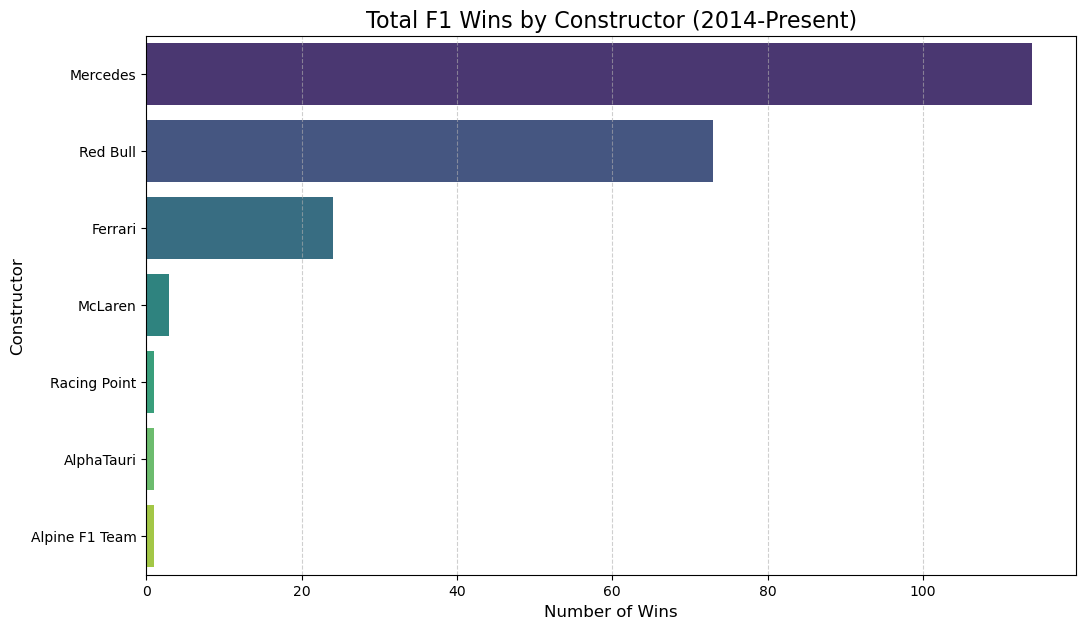

In [3]:

df_wins = pd.read_sql_query(sql_query_wins, engine)

plt.figure(figsize=(12, 7))
sns.barplot(data=df_wins, x='total_wins', y='constructor_name', palette='viridis')

plt.title('Total F1 Wins by Constructor (2014-Present)', fontsize=16)
plt.xlabel('Number of Wins', fontsize=12)
plt.ylabel('Constructor', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

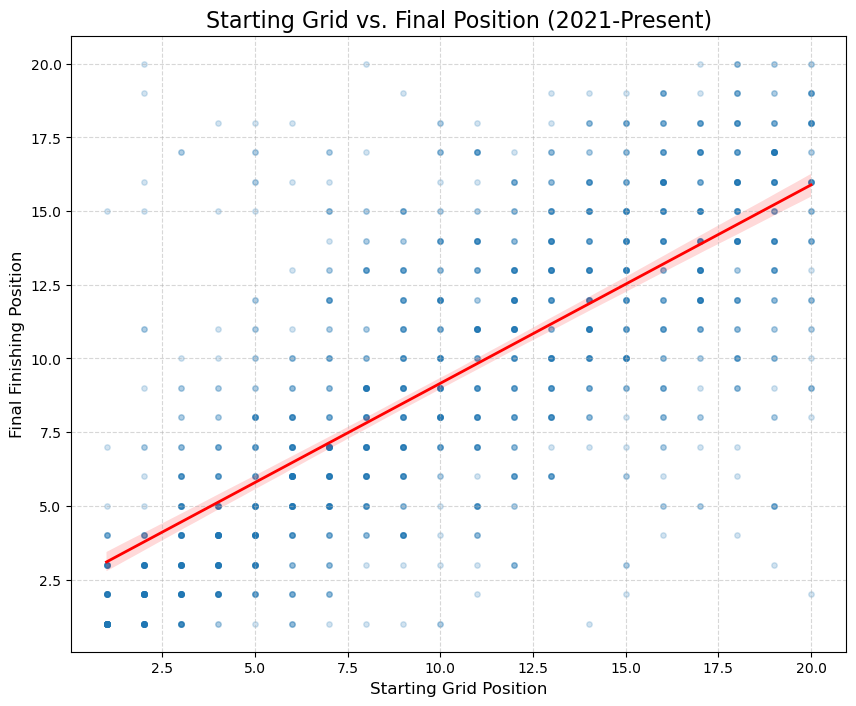

In [4]:

sql_query_grid_finish = """
SELECT
    grid,
    "position"
FROM
    results
WHERE
    grid > 0
    AND "raceId" IN (SELECT "raceId" FROM races WHERE year > 2020);
"""

df_grid_finish = pd.read_sql_query(sql_query_grid_finish, engine)

plt.figure(figsize=(10, 8))
sns.regplot(data=df_grid_finish, x='grid', y='position',
            scatter_kws={'alpha':0.2, 's':15},
            line_kws={'color':'red', 'linewidth':2})

plt.title('Starting Grid vs. Final Position (2021-Present)', fontsize=16)
plt.xlabel('Starting Grid Position', fontsize=12)
plt.ylabel('Final Finishing Position', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [5]:

sql_pre_race = """
SELECT 
    r."raceId", r.year, r.round, r."circuitId", r.date,
    q."driverId", q."constructorId", q.position AS qualifying_position
FROM races r
JOIN qualifying q ON r."raceId" = q."raceId"
WHERE r.year >= 2010;
"""
df_model_base = pd.read_sql_query(sql_pre_race, engine)

df_drivers = pd.read_sql_query('SELECT "driverId", dob FROM drivers', engine)
df_results = pd.read_sql_query('SELECT "raceId", "driverId", "position", points FROM results', engine)

df_model_base.columns = df_model_base.columns.str.lower()
df_drivers.columns = df_drivers.columns.str.lower()
df_results.columns = df_results.columns.str.lower()

df_model = pd.merge(df_model_base, df_drivers, on='driverid', how='left')
df_model = pd.merge(df_model, df_results, on=['raceid', 'driverid'], how='left')

df_model['date'] = pd.to_datetime(df_model['date'])
df_model['dob'] = pd.to_datetime(df_model['dob'])

print("Base DataFrame for modeling created successfully.")
print(df_model.head())

Base DataFrame for modeling created successfully.
   raceid  year  round  circuitid       date  driverid  constructorid  \
0     995  2018      7          7 2018-06-10       154            210   
1    1020  2019     11         10 2019-07-28        20              6   
2     337  2010      1          3 2010-03-14        20              9   
3     337  2010      1          3 2010-03-14        13              6   
4     337  2010      1          3 2010-03-14         4              6   

   qualifying_position        dob  position  points  
0                   20 1986-04-17      12.0     0.0  
1                   20 1987-07-03       2.0    18.0  
2                    1 1987-07-03       4.0    12.0  
3                    2 1981-04-25       2.0    18.0  
4                    3 1981-07-29       1.0    25.0  


In [6]:
df_model = df_model.sort_values(by=['date', 'round'])


df_model['driver_age'] = (df_model['date'] - df_model['dob']).dt.days / 365.25

df_model['driver_points_rolling_5'] = df_model.groupby('driverid')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df_model['driver_position_rolling_5'] = df_model.groupby('driverid')['position'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df_model['constructor_points_rolling_5'] = df_model.groupby('constructorid')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

print("Feature engineering complete.")
df_model.tail()

Feature engineering complete.


,raceid,year,round,circuitid,date,driverid,constructorid,qualifying_position,dob,position,points,driver_age,driver_points_rolling_5,driver_position_rolling_5,constructor_points_rolling_5
6187,1133,2024,13,11,2024-07-21,815,9,16,1990-01-26,7.0,6.0,34.483231,2.0,10.666667,8.8
6188,1133,2024,13,11,2024-07-21,847,131,17,1998-02-15,8.0,5.0,26.428474,12.4,3.250000,15.4
6189,1133,2024,13,11,2024-07-21,855,15,18,1999-05-30,19.0,0.0,25.144422,0.0,15.800000,0.0
6190,1133,2024,13,11,2024-07-21,839,214,19,1996-09-17,18.0,0.0,27.841205,0.4,12.000000,0.4
6191,1133,2024,13,11,2024-07-21,842,214,20,1996-02-07,NaN,0.0,28.451745,1.2,9.500000,0.2


In [7]:
target = df_model['position']
features = df_model[[
    'year',
    'round',
    'circuitid',
    'qualifying_position',
    'driver_age',
    'driver_points_rolling_5',
    'driver_position_rolling_5',
    'constructor_points_rolling_5'
]].copy() 
features = features.fillna(0)

target = target.dropna()
features = features.loc[target.index]

print("Features and target are now defined with no data leakage.")

Features and target are now defined with no data leakage.


In [8]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [9]:


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
ml_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
                           max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

ml_model.fit(X_train, y_train)

predictions = ml_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance:
Mean Absolute Error (MAE): 2.41
Root Mean Squared Error (RMSE): 3.15


In [10]:
!pip install google-generativeai

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import google.generativeai as genai
GENAI_API_KEY = os.getenv("GEMINI_API_KEY") 
genai.configure(api_key=GENAI_API_KEY)

In [12]:
sample = X_test.sample(1, random_state=42)
sample_target = y_test.loc[sample.index].iloc[0]
predicted_position = ml_model.predict(sample)[0]

original_index = sample.index[0]
sample_full_details = df_model.loc[original_index]

driverid = sample_full_details['driverid']
constructorid = sample_full_details['constructorid']
raceid = sample_full_details['raceid']

driver_name = pd.read_sql_query(f'SELECT forename, surname FROM drivers WHERE "driverId" = {driverid}', engine).iloc[0].str.cat(sep=' ')
constructor_name = pd.read_sql_query(f'SELECT name FROM constructors WHERE "constructorId" = {constructorid}', engine).iloc[0]['name']
race_name = pd.read_sql_query(f'SELECT name FROM races WHERE "raceId" = {raceid}', engine).iloc[0]['name']

prompt_template = f"""
You are an expert F1 sports analyst. Your task is to provide a short, insightful prediction for an upcoming race based on the data provided. Be concise and sound like a real commentator.

Race Details:
- Grand Prix: {race_name}
- Driver: {driver_name}
- Team: {constructor_name}
- Starting Position: {sample['qualifying_position'].iloc[0]}

Key Pre-Race Stats:
- Driver's Average Finish in Last 5 Races: {sample['driver_position_rolling_5'].iloc[0]:.1f}
- Team's Average Points in Last 5 Races: {sample['constructor_points_rolling_5'].iloc[0]:.1f}

Our machine learning model's prediction for the final finishing position is: {predicted_position:.0f}

Based on all this information, write a 2-3 sentence race prediction summary.
"""

genai_model = genai.GenerativeModel('gemini-2.5-flash')
response = genai_model.generate_content(prompt_template)

print("--- F1 Oracle Prediction ---")
print(prompt_template)
print("\n--- AI Analyst Commentary ---")
print(response.text)
print(f"\n--- Actual Race Result ---")
print(f"The driver's actual finishing position was: {int(sample_target)}")

--- F1 Oracle Prediction ---

You are an expert F1 sports analyst. Your task is to provide a short, insightful prediction for an upcoming race based on the data provided. Be concise and sound like a real commentator.

Race Details:
- Grand Prix: Indian Grand Prix
- Driver: Jérôme d'Ambrosio
- Team: Virgin
- Starting Position: 23

Key Pre-Race Stats:
- Driver's Average Finish in Last 5 Races: 19.0
- Team's Average Points in Last 5 Races: 0.0

Our machine learning model's prediction for the final finishing position is: 19

Based on all this information, write a 2-3 sentence race prediction summary.


--- AI Analyst Commentary ---
Starting P23, Jérôme d'Ambrosio and Virgin face a challenging race in India. Given his average finish of 19th and the team's lack of points recently, a similar outcome seems highly probable. Expect d'Ambrosio to battle hard, but a finish around the 19th position, as our model predicts, looks to be the ceiling.

--- Actual Race Result ---
The driver's actual fini

In [14]:
import google.generativeai as genai

GENAI_API_KEY = os.getenv("GEMINI_API_KEY") 

genai.configure(api_key=GENAI_API_KEY)

print("Available models:")
for model in genai.list_models():
    if 'generateContent' in model.supported_generation_methods:
        print(model.name)

Available models:
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-flash-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5

In [15]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


## Feature Importance Plot ##
This plot shows the average impact of each feature on the model's prediction magnitude.


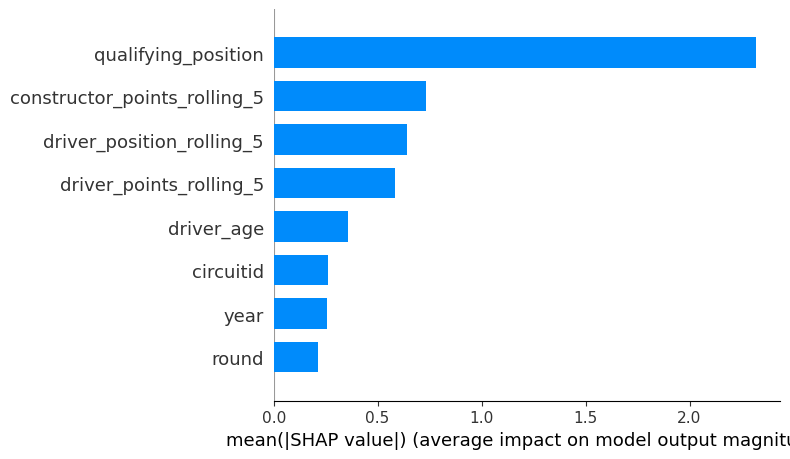


## Single Prediction Breakdown (Force Plot) ##
This plot shows how each feature contributed to a single specific prediction.
Red features pushed the prediction higher (worse finish), blue features pushed it lower (better finish).


In [16]:
import shap
explainer = shap.Explainer(ml_model)

shap_values = explainer(X_test)

print("## Feature Importance Plot ##")
print("This plot shows the average impact of each feature on the model's prediction magnitude.")
shap.summary_plot(shap_values, X_test, plot_type="bar")

print("\n## Single Prediction Breakdown (Force Plot) ##")
print("This plot shows how each feature contributed to a single specific prediction.")
print("Red features pushed the prediction higher (worse finish), blue features pushed it lower (better finish).")
shap.initjs() # required for force plot rendering in notebooks
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0,:])

In [17]:
import pickle


df_drivers_names = pd.read_sql_query('SELECT "driverId", forename || \' \' || surname AS driver_name FROM drivers', engine)
df_constructors_names = pd.read_sql_query('SELECT "constructorId", name AS constructor_name FROM constructors', engine)

df_drivers_names.columns = df_drivers_names.columns.str.lower()
df_constructors_names.columns = df_constructors_names.columns.str.lower()

df_final = pd.merge(df_model, df_drivers_names, on='driverid', how='left')
df_final = pd.merge(df_final, df_constructors_names, on='constructorid', how='left')

final_feature_columns = [
    'year', 'round', 'circuitid', 'qualifying_position', 'driver_age',
    'driver_points_rolling_5', 'driver_position_rolling_5',
    'constructor_points_rolling_5', 'driver_name', 'constructor_name'
]

features_with_names = df_final[final_feature_columns].copy()
features_with_names = features_with_names.fillna(0)

with open('f1_prediction_model.pkl', 'wb') as f:
    pickle.dump(ml_model, f)

features_with_names.to_csv('f1_features.csv', index=False)

print("Model and features (with names) saved successfully.")

Model and features (with names) saved successfully.


In [18]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import sys
print(sys.executable)

C:\ProgramData\anaconda3\python.exe
